In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
directory = "./Logs/"
save_path = "./Saved/"

from load_logs import *
from evaluation import *
from features import *
from visualize import *

logs, log_labels = read_logs_and_labels("./Saved/logs.txt", "./Saved/labels.txt")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import pickle
import sys
import random
import hdbscan
import itertools

from bregclus.models import BregmanHard
from bregclus.divergences import euclidean
from multiprocessing import get_context
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples
from scipy import sparse
from multiprocessing import Pool
from math import sqrt
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [3]:
#Time to define necessary functions
#Since this is based on a knn idea we will need to calculate euclidean distance

In [4]:
#Nearest neighbour - gets x number of nearest nodes
def nearest(x, y_row, neighbors, labels): #specify number of neighbours to return
    distances = np.linalg.norm(x - y_row, axis=1)#numpy array of distances
    size, y = np.shape(x)
    itera = np.arange(0,size).reshape(-1,1)
    for i in range(len(labels)):
        distances = np.c_[distances,labels[i]]
    distances = np.c_[distances,itera]
    distances = distances[np.argsort(distances[:, 0])]
    neighborsList, neighborsLabels, iteraList = list(), list(), list()
    for i in range(neighbors): #27093
        neighborsList.append(distances[i][0])
        neighborsLabels.append(distances[i][1:len(distances[i])-1])
        iteraList.append(distances[i][len(distances[i])-1])
    return neighborsList,neighborsLabels,iteraList

In [5]:
def lookUp(labels, lookup, which):
    arr = np.array(labels)
    x,y = np.shape(arr)
    indices = np.argwhere(arr[which] == lookup)
    return indices

In [6]:
def firstTrue(boolArr):
    for i in range(len(boolArr)):
        if boolArr[i] == True:
            return i

In [7]:
def recluster(x,y,silVal, itera): #Recluster based on silhouette coefficient (i.e whichever node here has a higher coefficient)
    print(itera)
    if silVal[int(itera[0])] > silVal[int(itera[1])]:
        return x
    else:
        return y    

In [8]:
def isEqual(x,y):
    if x == y:
        return True
    else:
        return False

In [9]:
#Current and nearest are same cluster then true otherwise false
def checkClus(x,y):
    boolArr = list(map(isEqual, x, y))
    print(boolArr)
    return boolArr

In [24]:
def consensus(x,y,labels,silVal,itera,silVal1): #form boolean array from checkClus, if majority are true then the node should be in the cluster, otherwise not
    print(x)
    boolArr=checkClus(x,y)
    trueCount, total,first = sum(boolArr), len(boolArr), firstTrue(boolArr)
    print(trueCount/total)
    if (trueCount)/(total) == 1:
        #pass vote of node being in cluster
        #if (boolArr[0] == False): #when consensus is passed but what our clustering is based on does not agree
            #print("did not fully pass")
            #ind1 = lookUp(labels,x[first],first)#need to sort this out such that we determine if the nearest nodes value is better
            #ind2 = lookUp(labels,x[0],0)#or if the current nodes value is better
            #ind3 = lookUp(labels,y[0],0)
            #firstValList = np.intersect1d(ind1, ind2, assume_unique=False, return_indices=False)
            #x1 = np.shape(firstValList)
            #secondValList = np.intersect1d(ind1, ind3, assume_unique=False, return_indices=False)
            #x2 = np.shape(secondValList)
            #if x1 > x2: #determine which node classification is agreed on more
                #print("replacing "+ str(x[0]) +" with "+ str(x[0]) + " at "+str(itera))
                #return True, x[0]
            #else:
                #print("replacing "+ str(x[0]) +" with "+ str(y[0])+ " at "+str(itera))
                #return True, y[0]
            #return True, recluster(x[0],y[0],silVal1,itera)
        return True, x[0]
    elif (trueCount)/(total) > 0 and (boolArr[0] == False): #when consensus is passed but what our clustering is based on does not agree
        print("did not fully pass")
        ind1 = lookUp(labels,x[first],first)#need to sort this out such that we determine if the nearest nodes value is better
        ind2 = lookUp(labels,x[0],0)#or if the current nodes value is better
        ind3 = lookUp(labels,y[0],0)
        firstValList = np.intersect1d(ind1, ind2, assume_unique=False, return_indices=False)
        x1 = np.shape(firstValList)
        secondValList = np.intersect1d(ind1, ind3, assume_unique=False, return_indices=False)
        x2 = np.shape(secondValList)
        if x1 > x2: #determine which node classification is agreed on more
            print("replacing "+ str(x[0]) +" with "+ str(x[0]) + " at "+str(itera))
            return True, x[0]
        else:
            print("replacing "+ str(x[0]) +" with "+ str(y[0])+ " at "+str(itera))
            return True, y[0]
    elif (boolArr[0] == True):
        return True, x[0]
    else:
        print("failed!")
        
        #pass the false vote - node is not in cluster
        return False, recluster(x[0],y[0],silVal1,itera)

In [11]:
def comprehension(X,labels,x,itera,silVal):
    silValed = silVal
    lb = list()
    lb.append(labels[0][itera])
    lb.append(labels[1][itera])
    lb.append(labels[2][itera])
    lb.append(labels[3][itera])
    lb.append(labels[4][itera])
    labelsed = (np.reshape(np.array(labels),(-1,3))).tolist()
    labs = labels
    it = list()
    if itera > 0:
        X = np.delete(X,[0,itera-1], axis = 0)
        labels = np.delete(labels,[0,itera-1], axis = 1)
        silValed = np.delete(silVal,[0,itera-1], axis = 0)
    near, tempLab,inds = nearest(X, x, 2, labels)
    it.append(itera)
    it.append(inds[1])
    print(tempLab[1])
    boolArr1,res1 = consensus(lb,tempLab[1],labs,silValed,it,silVal)
    if boolArr1 == True:
        return int(res1) #need to sort this out such that we assign a valid cluster number
    else: #recluster somehow
        print("Failed - reclustering")
        return int(res1)

    

In [12]:
def takeConsensus(X, labels,silVal):
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X,x),itertools.repeat(labels,x), X,i,itertools.repeat(silVal,x))]
    print("running consensus")
    #p = Pool(6)#Multiprocessing to speed up run time
    with Pool() as p:
    #conList = [comprehension(X, labels, x) for x in X]
        conList = p.starmap(comprehension, tasks)
    #conList = starmap(comprehension, tasks)
    #for i in range(len(X)):
        #boolArr = list()
        #near, tempLab = nearest(X_, X[i], 3, labels) #do not repeat values in proximity
        #X_ = np.delete(X, i, axis = 0) #This will exclude the current node from our next nearest calculations
        #boolArr1 = checkClus(tempLab[0],tempLab[1])
       # boolArr2 = checkClus(tempLab[0],tempLab[2])
        #if consensus(boolArr1):
          #  conList.append(tempLab[0][0]) #need to sort this out such that we assign a valid cluster number
        #elif consensus(boolArr2): #here we check its second nearest neighbor before reclustering
         #   conList.append(tempLab[1][0])
       # else: #recluster somehow
           # conList.append(tempLab[0][0])
        #print(conList)
    return conList

In [13]:
labels_ = log_labels
            
X = get_features(logs, 2, 70)
X = X.toarray()

idxs = np.where(np.all(X == 0, axis=1))

X = np.delete(X, idxs, axis=0)
labels_ = np.delete(labels_, idxs)
## K Means Labels
kmeans = KMeans(init="k-means++", n_clusters=10,random_state=0).fit(X)
kLabels = kmeans.labels_

## DBSCAN Labels
DBmodel = DBSCAN(eps=0.4,min_samples=200,algorithm="auto",metric="cosine")
DBmodel.fit(X)
dbLabels = DBmodel.labels_

## Birch Label
birchmodel = Birch(n_clusters=10, branching_factor=100, threshold=0.5, compute_labels=True)
Y = birchmodel.fit_transform(X)
birchLabels = birchmodel.labels_

#HDBScan Labels
model = hdbscan.HDBSCAN(min_cluster_size=500,min_samples=100,cluster_selection_epsilon=0.5,
                                        metric="euclidean",algorithm='best')
model.fit(X)
hdbLabels = model.labels_


In [43]:
#Bregman Labels
bhc = BregmanHard(n_clusters=10, divergence=euclidean)
bhc.fit(X)
bLabels = bhc.predict(X)
print(np.shape(np.nonzero(bLabels)))

(1, 22985)


In [14]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 10)
acLabels = model.fit_predict(X)
acresults = evaluate_clustering('Agglomerative Bigram Clustering', X, labels_, acLabels)
print(acresults)

['Agglomerative Bigram Clustering', '0.79', '0.85', '0.82', '0.60', '0.82', '0.66']


In [15]:
silVal = silhouette_samples(X, kLabels)

In [29]:
#testing
labels = list()
labels.append(kLabels)
labels.append(birchLabels)
labels.append(acLabels)#had better results than bregmans
labels.append(hdbLabels)
labels.append(dbLabels)


#x,y,z = nearest(X, X[0], 2, labels)
#print(x)
#print(y)
#print(z)
#boolArr = checkClus(y[0],y[1])
#print(boolArr)

#print(consensus(y[0],y[1],labels,silVal))
#x,y = np.shape(X)
#print(x)

In [17]:
print(np.shape(labels))
print(np.shape(X))

(5, 27093)
(27093, 1832)


In [ ]:
itertools.repeat(silVal, x)

In [ ]:
print(np.shape(silVal))
print(np.shape(X))
print(np.shape(labels))

In [ ]:
print(recluster(labels[0][26903],labels[0][6036],silVal, [26903,6036]))
print(silVal[26903])
print(silVal[6036])

In [30]:
import worker

if __name__ == '__main__':
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X, x),itertools.repeat(labels, x), X, i, itertools.repeat(silVal, x))]
    p = Pool(4)
    cLabels = p.starmap(worker.comprehension, tasks)
    print(cLabels)
    p.close()
    p.join()

[6, 6, 3, 4, 8, 5, 3, 6, 5, 4, 1, 1, 4, 6, 3, 8, 5, 5, 9, 1, 9, 4, 2, 2, 6, 1, 4, 1, 1, 5, 1, 6, 6, 4, 3, 4, 1, 4, 6, 1, 2, 8, 0, 3, 3, 6, 8, 8, 0, 5, 4, 1, 1, 0, 6, 8, 6, 2, 8, 8, 5, 6, 2, 5, 9, 5, 2, 8, 2, 0, 6, 3, 6, 8, 3, 1, 4, 1, 5, 6, 6, 8, 5, 1, 6, 4, 8, 8, 1, 6, 3, 3, 3, 2, 9, 1, 1, 6, 0, 8, 7, 6, 6, 9, 6, 5, 2, 1, 8, 3, 2, 7, 2, 1, 3, 6, 1, 4, 6, 6, 4, 8, 4, 7, 6, 8, 3, 5, 7, 4, 1, 5, 6, 3, 4, 5, 4, 6, 5, 3, 8, 1, 8, 6, 5, 4, 8, 1, 1, 2, 6, 8, 5, 8, 9, 5, 4, 1, 0, 5, 1, 4, 1, 7, 8, 4, 9, 1, 3, 9, 6, 5, 9, 3, 8, 6, 8, 6, 6, 5, 2, 3, 8, 4, 9, 1, 3, 2, 6, 8, 0, 9, 6, 5, 3, 2, 3, 5, 6, 3, 5, 8, 0, 8, 5, 6, 6, 7, 1, 3, 1, 1, 5, 5, 5, 1, 8, 2, 7, 9, 8, 6, 5, 1, 0, 4, 2, 2, 9, 6, 3, 4, 1, 8, 8, 9, 6, 6, 5, 4, 1, 1, 7, 8, 3, 1, 4, 1, 2, 5, 5, 3, 3, 6, 1, 5, 6, 5, 6, 2, 0, 1, 5, 9, 2, 2, 3, 2, 6, 2, 8, 9, 8, 4, 2, 8, 3, 5, 1, 3, 1, 7, 6, 4, 5, 4, 5, 3, 4, 2, 6, 8, 0, 0, 7, 6, 7, 9, 5, 3, 4, 8, 4, 5, 9, 1, 7, 1, 6, 3, 6, 9, 6, 6, 8, 9, 8, 6, 6, 5, 3, 1, 8, 4, 8, 6, 8, 4, 4, 4, 2, 1, 2, 

In [31]:
print(kLabels[11765])
print(cLabels[11765])
print(kLabels - cLabels)
print(np.shape(np.nonzero(kLabels - cLabels)))
#12 nodes changed with db, hdb (in order) - hdb is a better option
#11 nodes changed with hdb, birch
#10 nodes changed with hdc,ac,birch and db

8
1
[0 0 0 ... 0 0 0]
(1, 11)


In [19]:
print(set(cLabels) - set(kLabels))

set()


In [ ]:
#print((np.reshape(np.array(labels),(-1,3))).tolist())
x = list()
x.append(labels[0][3144])
x.append(labels[1][3144])
x.append(labels[2][3144])
y = list()
y.append(labels[0][11981])
y.append(labels[1][11981])
y.append(labels[2][11981])
recluster(labels[0][3144],labels[0][11981],silVal, [3144, 11981.0])

In [23]:
print(comprehension(X,labels,X[4676],4676,silVal)) #did not fully pass
#[3590.0, 1393.0]
#Succesful recluster
#did not fully pass
#[1002.0, 19211.0]
#Succesful recluster
#failed!
#[4676.0, 11270.0]
#Succesful recluster
#Failed - reclustering
#did not fully pass
#[3144.0, 1403.0]
#Succesful recluster
#did not fully pass
#[8627.0, 24408.0]
#fixed issue where passing wrong label list
print(str(labels[0][4676]) + " labels")


ValueError: operands could not be broadcast together with shapes (27091,1832) (5,) 

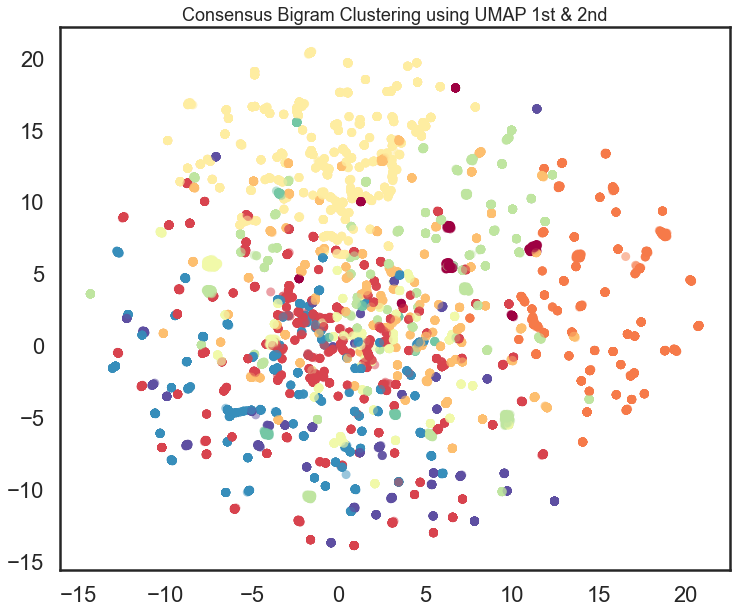

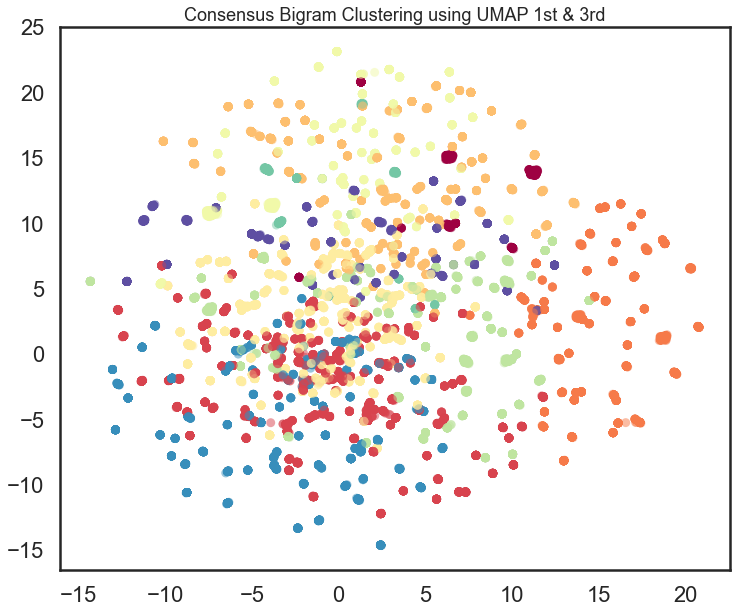

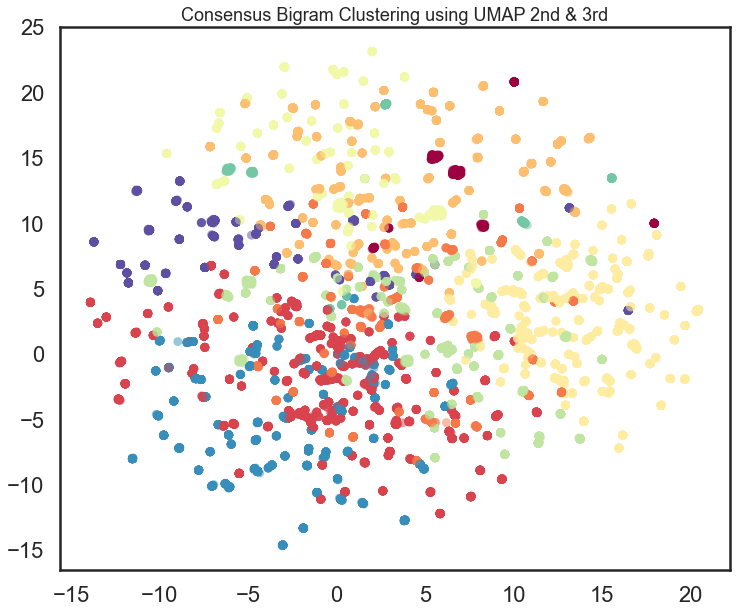

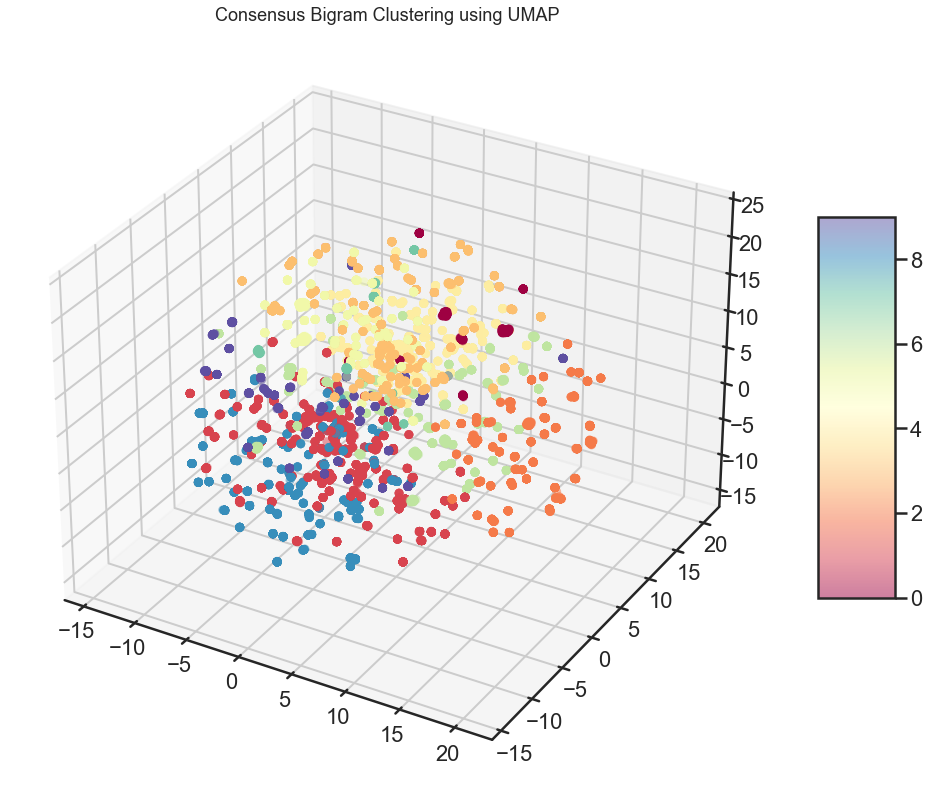

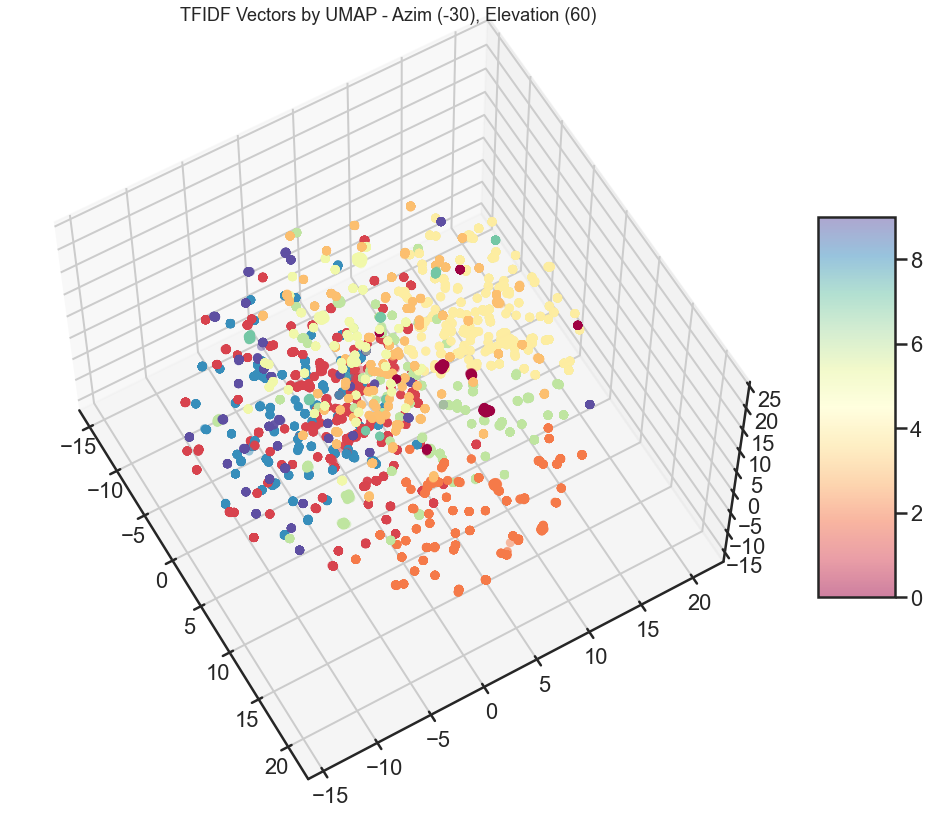

In [32]:
plot_clusters("Consensus Bigram Clustering using UMAP", X, cLabels)

In [33]:
results = evaluate_clustering('Consensus Bigram Clustering', X, labels_, cLabels)
print(results)

['Consensus Bigram Clustering', '0.83', '0.86', '0.85', '0.70', '0.85', '0.73']


In [34]:
labels_ = log_labels
            
X = get_features(logs, 3, 90)
X = X.toarray()

idxs = np.where(np.all(X == 0, axis=1))

X = np.delete(X, idxs, axis=0)
labels_ = np.delete(labels_, idxs)
## K Means Labels
kmeans = KMeans(init="k-means++", n_clusters=10,random_state=0).fit(X)
kLabels = kmeans.labels_

## DBSCAN Labels
DBmodel = DBSCAN(eps=0.4,min_samples=200,algorithm="auto",metric="cosine")
DBmodel.fit(X)
dbLabels = DBmodel.labels_

## Birch Label
birchmodel = Birch(n_clusters=10, branching_factor=100, threshold=0.5, compute_labels=True)
Y = birchmodel.fit_transform(X)
birchLabels = birchmodel.labels_

#HDBScan Labels
model = hdbscan.HDBSCAN(min_cluster_size=500,min_samples=100,cluster_selection_epsilon=0.5,
                                        metric="euclidean",algorithm='best')
model.fit(X)
hdbLabels = model.labels_

In [35]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 10)
acLabels = model.fit_predict(X)
acresults = evaluate_clustering('Agglomerative Bigram Clustering', X, labels_, acLabels)
print(acresults)

['Agglomerative Bigram Clustering', '0.80', '0.88', '0.84', '0.66', '0.84', '0.71']


In [36]:
labels = list()
labels.append(kLabels)
labels.append(birchLabels)
labels.append(acLabels)#had better results than bregmans
labels.append(hdbLabels)
labels.append(dbLabels)

In [45]:
print(np.shape(labels))
labelsed = (np.reshape(np.array(labels),(-1,5))).tolist()
print(np.shape(X))

(5, 27044)
(27044, 1968)


In [46]:
import worker

if __name__ == '__main__':
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X, x),itertools.repeat(labels, x), X, i, itertools.repeat(silVal, x))]
    p = Pool(4)
    cLabels = p.starmap(worker.comprehension, tasks)
    print(cLabels)
    p.close()
    p.join()

[7, 7, 6, 1, 2, 5, 6, 7, 5, 1, 2, 2, 1, 7, 6, 2, 8, 5, 3, 2, 3, 1, 0, 0, 4, 2, 1, 2, 2, 5, 2, 4, 3, 1, 6, 1, 2, 1, 7, 2, 0, 2, 9, 6, 6, 7, 2, 2, 9, 5, 1, 2, 2, 9, 7, 2, 4, 0, 2, 2, 5, 4, 0, 8, 3, 8, 0, 2, 0, 9, 7, 6, 4, 2, 6, 2, 1, 2, 8, 7, 4, 2, 5, 2, 1, 2, 2, 2, 7, 6, 6, 6, 0, 3, 2, 2, 4, 9, 2, 5, 7, 7, 3, 4, 8, 0, 2, 2, 6, 0, 5, 0, 2, 6, 2, 1, 4, 7, 1, 2, 1, 5, 4, 2, 6, 5, 8, 1, 2, 6, 7, 6, 1, 8, 1, 7, 5, 6, 2, 2, 2, 7, 8, 1, 2, 2, 2, 0, 7, 2, 5, 2, 3, 8, 1, 2, 9, 5, 2, 1, 2, 5, 2, 1, 3, 2, 6, 3, 7, 5, 3, 6, 2, 4, 2, 7, 7, 5, 0, 6, 2, 1, 3, 2, 6, 0, 7, 2, 9, 3, 7, 8, 6, 0, 6, 5, 7, 6, 5, 2, 9, 2, 5, 7, 7, 8, 2, 6, 2, 2, 5, 5, 8, 2, 2, 0, 5, 3, 2, 7, 5, 2, 9, 1, 0, 0, 3, 7, 6, 1, 2, 2, 2, 3, 4, 7, 5, 1, 2, 2, 5, 2, 6, 2, 1, 2, 0, 5, 5, 6, 6, 4, 2, 5, 4, 5, 7, 0, 9, 2, 8, 3, 0, 0, 6, 0, 7, 0, 2, 3, 2, 1, 0, 2, 6, 5, 2, 6, 2, 5, 7, 1, 5, 1, 5, 6, 1, 0, 7, 2, 9, 9, 5, 7, 5, 3, 8, 6, 1, 2, 1, 5, 3, 2, 8, 2, 7, 6, 4, 3, 7, 7, 2, 3, 2, 7, 7, 5, 6, 2, 2, 1, 2, 7, 2, 1, 1, 1, 0, 2, 0, 7, 7, 

C:\Users\Riley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\umap\spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


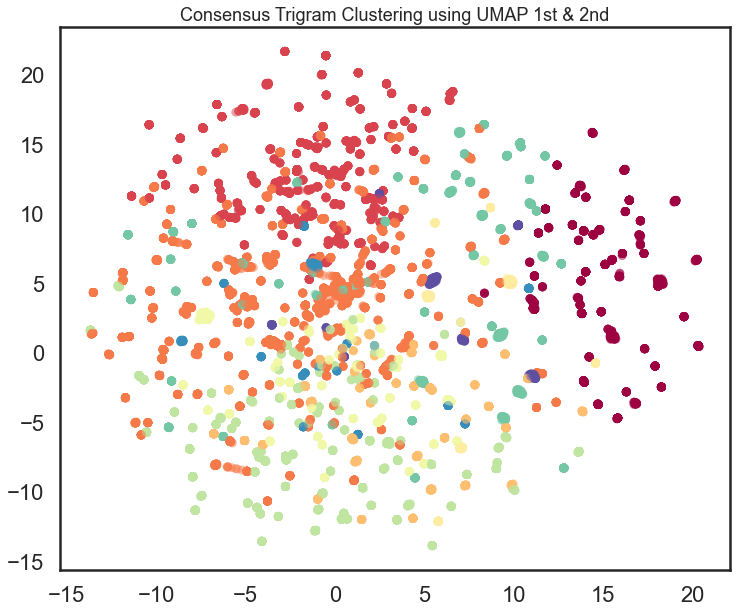

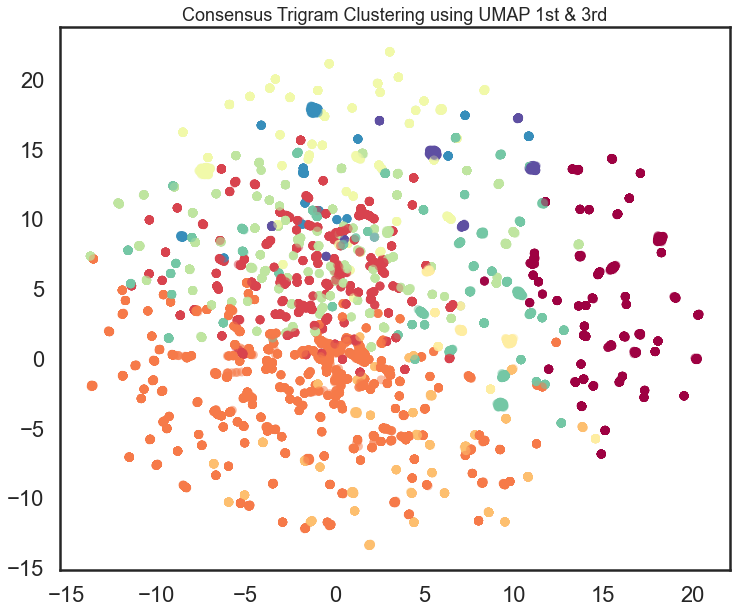

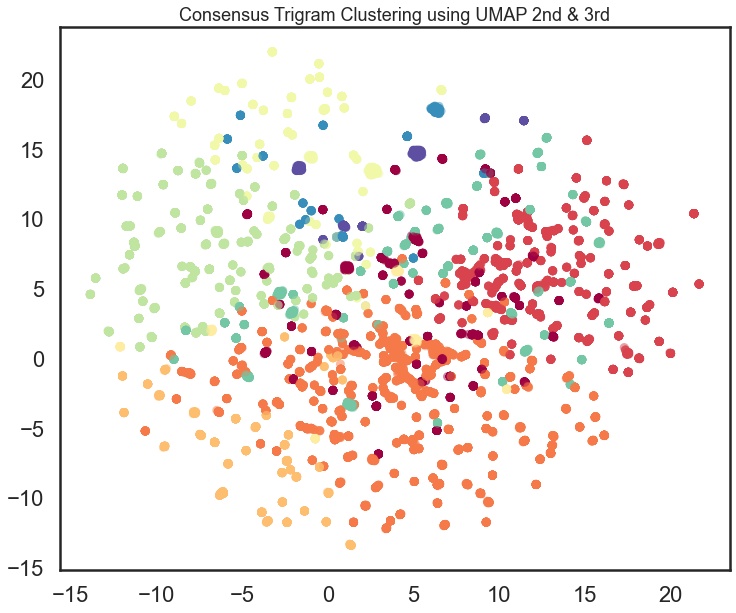

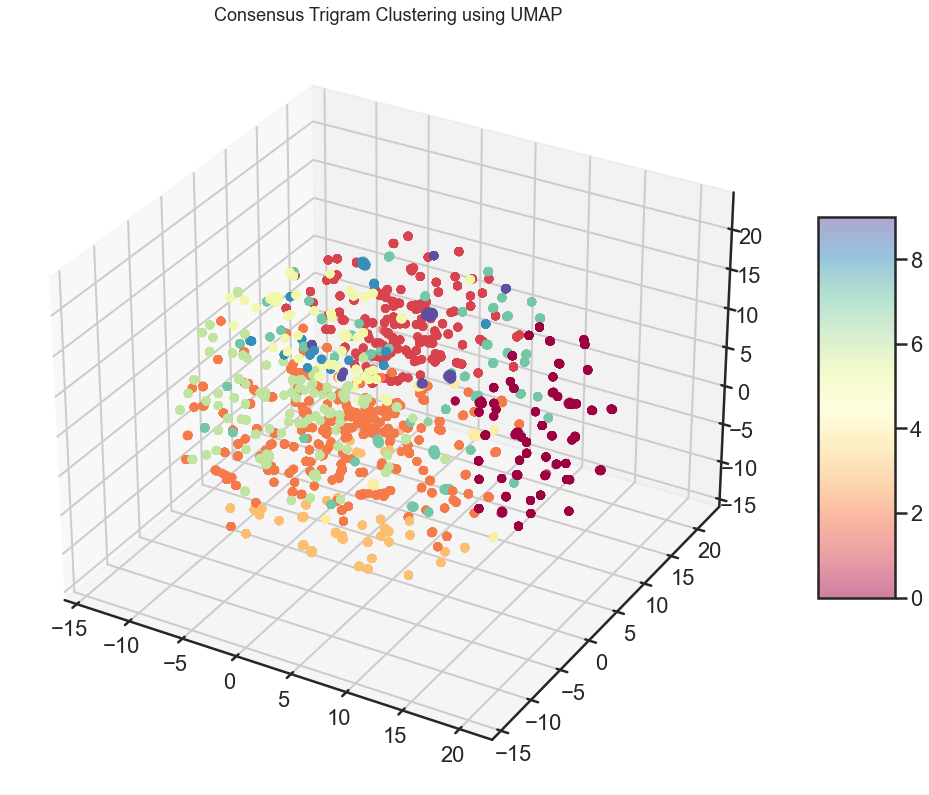

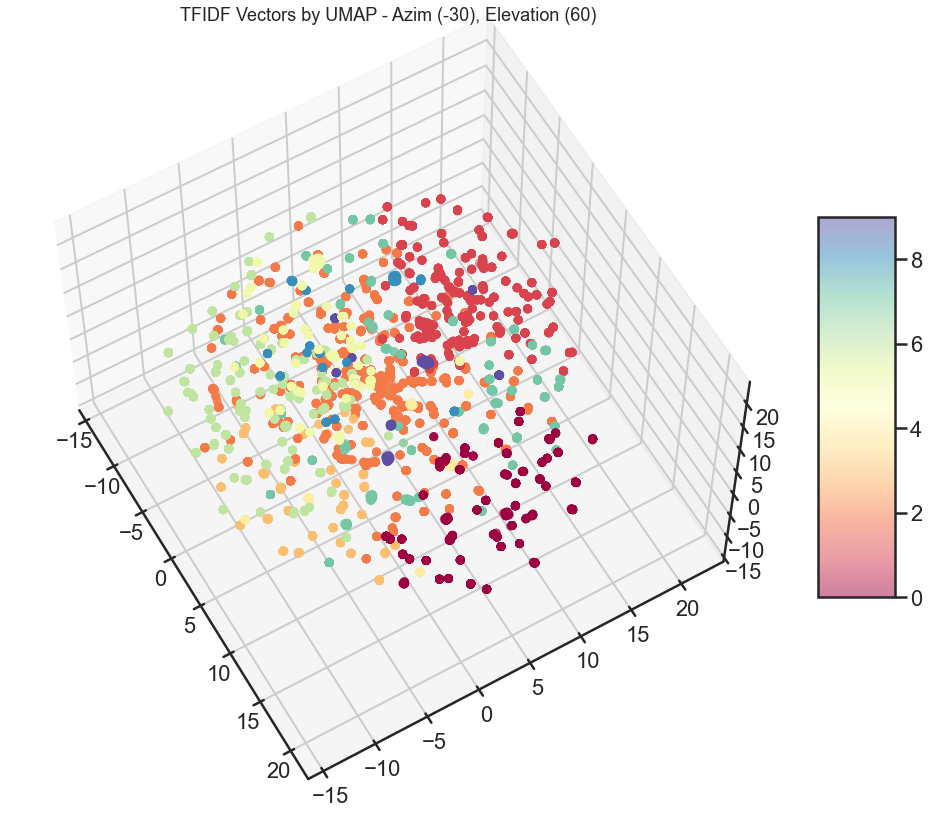

In [47]:
plot_clusters("Consensus Trigram Clustering using UMAP", X, cLabels)

In [48]:
results = evaluate_clustering('Consensus Bigram Clustering', X, labels_, cLabels)
print(results)

['Consensus Bigram Clustering', '0.83', '0.89', '0.86', '0.67', '0.86', '0.71']
